# Test Model for Lung Cancer Detection

First import the libraries:

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

## Load test set

In [2]:
preprocessed_data_folder = './stage1_preprocessed/'
batch_size = 10 # divide set into batches to prevent machine from running out of memory
data_shape = [250, 350, 350]

patients = os.listdir(preprocessed_data_folder)
patients.sort()

test_batches = []
current_test_batch = []
test_data_size = 0

for i in range(len(patients)):  
    if patients[i].startswith('.'): continue # ignore hidden files
    
    # test data
    if np.load(preprocessed_data_folder + patients[i])['set'] == 'test':
        current_test_batch.append(patients[i])
        
        #  if current test batch is full
        if (len(current_test_batch) == batch_size): 
            test_batches.append(current_test_batch)
            test_data_size += batch_size
            current_test_batch = []

# save the remaining test data
if len(current_test_batch) != 0:
    test_data_size += len(current_test_batch)
    # pad zeros to make its size equal to batch_size
    while (len(current_test_batch) != batch_size):
        current_test_batch.append(0)
    test_batches.append(current_test_batch)
    current_test_batch = []

test_batches = np.array(test_batches)

print('Test data size: {:d}, Number of test batches: {:d}'.format(
    test_data_size, test_batches.shape[0]))

Test data size: 198, Number of test batches: 20


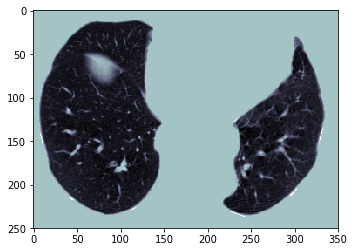

In [3]:
def read_batch(batch_files):
    
    # do not account the placeholder zeros for the batch size
    current_batch_size = batch_size - np.sum(batch_files == '0')
    
    batch_features = np.zeros((current_batch_size, data_shape[0], data_shape[1], data_shape[2], 1))
    batch_ids = []
    
    for i in range(len(batch_files)):
        if batch_files[i] != '0':
            data = np.load(preprocessed_data_folder + batch_files[i])
            batch_features[i,:,:,:,0] = data['data']
            batch_ids.append(batch_files[i][:32])

    return batch_features, batch_ids

test_features_batch_sample, test_ids_batch_sample = read_batch(test_batches[0])

plt.imshow(test_features_batch_sample[0,:,:,100,0], cmap=plt.cm.bone)
plt.show()

## Test model
Load Tensorflow model and apply it on the test set.

In [4]:
model_save_path = './model8_0'
prediction_save_path = './stage1_submission.csv'

cnn_graph = tf.Graph()
prediction_file = open(prediction_save_path, 'w')
prediction_file.write('id,cancer\n') # header line

with tf.Session(graph=cnn_graph) as sess:
    # load model
    loader = tf.train.import_meta_graph(model_save_path + '.meta')
    loader.restore(sess, model_save_path)
    
    # obtain tensors
    x = cnn_graph.get_tensor_by_name('x:0')
    y = cnn_graph.get_tensor_by_name('y:0')
    keep_prob = cnn_graph.get_tensor_by_name('keep_prob:0')
    logits = cnn_graph.get_tensor_by_name('logits:0')
    
    # use model to predict from test features
    # loop over test batches
    for batch_index in range(test_batches.shape[0]):
        test_features_batch, test_ids_batch = read_batch(test_batches[batch_index])
        predictions = sess.run(tf.nn.softmax(logits), feed_dict={
            x: test_features_batch,
            keep_prob: 1.
        })
        
        for test_index in range(len(test_ids_batch)):
            # save predictions to file
            prediction_file.write(test_ids_batch[test_index] + ',' + str(predictions[test_index,1]) + '\n')
            # print out predictions
            print('ID: ' + test_ids_batch[test_index] + ', Cancer probability: ' + str(predictions[test_index,1]))

prediction_file.close()

ID: 026470d51482c93efc18b9803159c960, Cancer probability: 0.221615
ID: 031b7ec4fe96a3b035a8196264a8c8c3, Cancer probability: 0.222471
ID: 03bd22ed5858039af223c04993e9eb22, Cancer probability: 0.135951
ID: 06a90409e4fcea3e634748b967993531, Cancer probability: 0.236084
ID: 07b1defcfae5873ee1f03c90255eb170, Cancer probability: 0.169519
ID: 0b20184e0cd497028bdd155d9fb42dc9, Cancer probability: 0.19874
ID: 12db1ea8336eafaf7f9e3eda2b4e4fef, Cancer probability: 0.170285
ID: 159bc8821a2dc39a1e770cb3559e098d, Cancer probability: 0.293295
ID: 174c5f7c33ca31443208ef873b9477e5, Cancer probability: 0.276521
ID: 1753250dab5fc81bab8280df13309733, Cancer probability: 0.280656
ID: 1cf8e778167d20bf769669b4be96592b, Cancer probability: 0.202124
ID: 1e62be2c3b6430b78ce31a8f023531ac, Cancer probability: 0.219386
ID: 1f6333bc3599f683403d6f0884aefe00, Cancer probability: 0.207591
ID: 1fdbc07019192de4a114e090389c8330, Cancer probability: 0.260475
ID: 2004b3f761c3f5dffb02204f1247b211, Cancer probability: 0.294